In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim  #优化
import numpy as np
import matplotlib.pyplot as plt  #绘图
import torchvision  #加载图片
from torchvision import transforms  #图片变换
from torch.utils.data import DataLoader

In [2]:

#对数据做归一化（-1，1）
transform = transforms.Compose([
    #将shanpe为（H,W，C）的数组或img转为shape为（C,H,W）的tensor
    transforms.ToTensor(),  #转为张量并归一化到【0，1】；数据只是范围变了，并没有改变分布
    transforms.Normalize(0.5, 0.5)  #数据归一化处理，将数据整理到[-1,1]之间；可让数据呈正态分布
])
#下载数据到指定的文件夹
train_ds = torchvision.datasets.MNIST('data',
                                      train=True,
                                      transform=transform,
                                      download=True)
#数据的输入部分
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)

In [3]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.linear1 = nn.Linear(100, 256 * 7 * 7)
        self.bn1 = nn.BatchNorm1d(256 * 7 * 7)
        self.deconv1 = nn.ConvTranspose2d(256, 128,
                                          kernel_size=(3, 3),
                                          stride=1,
                                          padding=1)  #生成（128，7，7）的二维图像
        self.bn2 = nn.BatchNorm2d(128)
        self.deconv2 = nn.ConvTranspose2d(128, 64,
                                          kernel_size=(4, 4),
                                          stride=2,
                                          padding=1)  #生成（64，14，14）的二维图像
        self.bn3 = nn.BatchNorm2d(64)
        self.deconv3 = nn.ConvTranspose2d(64, 1,
                                          kernel_size=(4, 4),
                                          stride=2,
                                          padding=1)  #生成（1,28,28）的二维图像

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = self.bn1(x)
        x = x.view(-1, 256, 7, 7)
        x = F.relu(self.deconv1(x))
        x = self.bn2(x)
        x = F.relu(self.deconv2(x))
        x = self.bn3(x)
        x = torch.tanh(self.deconv3(x))
        return x

In [4]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=2)
        self.bn = nn.BatchNorm2d(128)
        self.fc = nn.Linear(128 * 6 * 6, 1)

    def forward(self, x):
        x = F.dropout2d(F.leaky_relu(self.conv1(x)))
        x = F.dropout2d(F.leaky_relu(self.conv2(x)))  #(batch,128,6,6)
        x = self.bn(x)
        x = x.view(-1, 128 * 6 * 6)  #展平
        x = torch.sigmoid(self.fc(x))
        return x

In [5]:
#设备的配置
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#初化生成器和判别器把他们放到相应的设备上
gen = Generator().to(device)
dis = Discriminator().to(device)

In [6]:
#训练器的优化器
d_optimizer = optim.Adam(dis.parameters(), lr=0.0001)
#训练生成器的优化器
g_optimizer = optim.Adam(gen.parameters(), lr=0.0001)
#交叉熵损失函数
loss_fn = nn.BCELoss()

In [7]:
def generate_and_save_images(model, epoch, test_input):
    prediction = np.squeeze(model(test_input).detach().cpu().numpy())
    fig = plt.figure(figsize=(4, 4))
    for i in range(len(prediction)):  # range(16)
        plt.subplot(4, 4, i + 1)
        plt.imshow((prediction[i] + 1) / 2, cmap='gray')  # 恢复到(0,1)
        plt.axis('off')
        # plt.savefig('img/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [8]:
test_input = torch.randn(16, 100, device=device)  #16个长度为100的随机数

In [9]:
D_loss = []
G_loss = []

epoch: 0


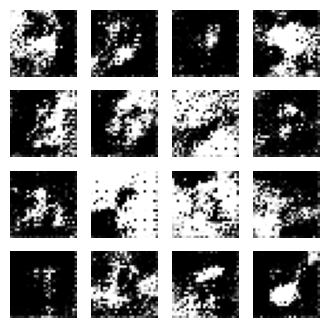

epoch: 1


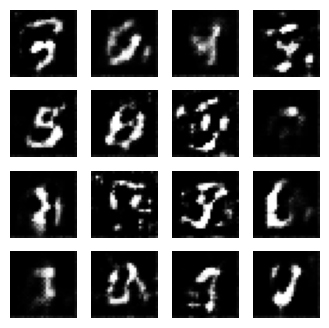

epoch: 2


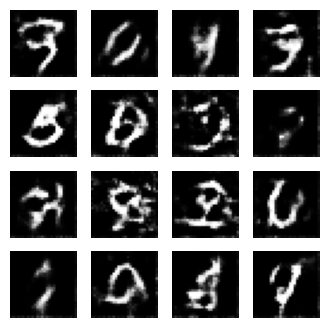

epoch: 3


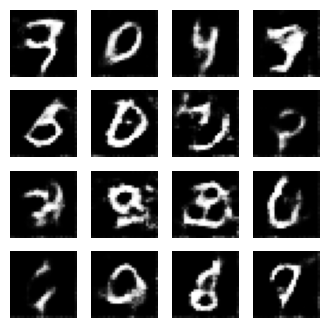

epoch: 4


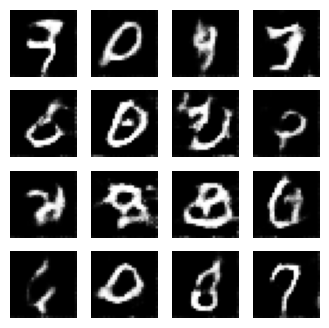

epoch: 5


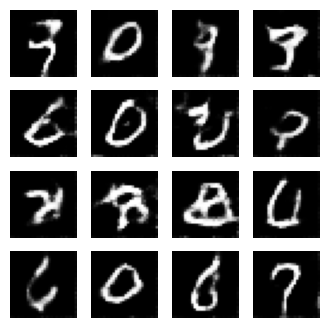

epoch: 6


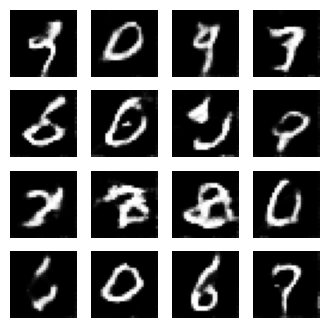

epoch: 7


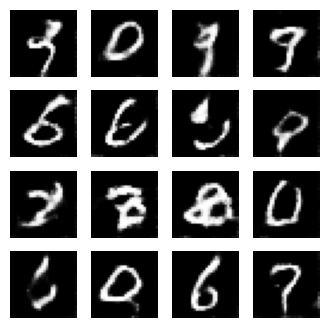

epoch: 8


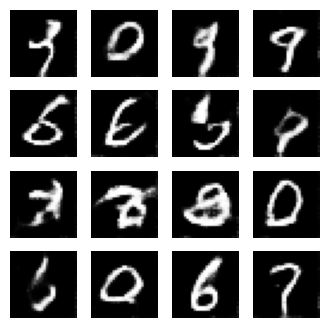

epoch: 9


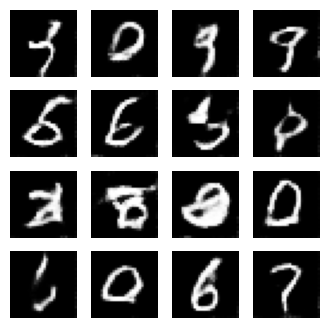

epoch: 10


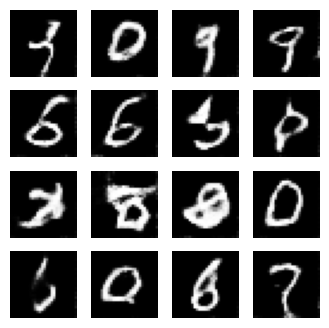

epoch: 11


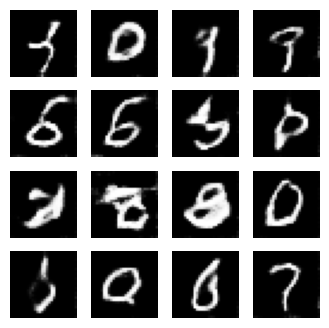

epoch: 12


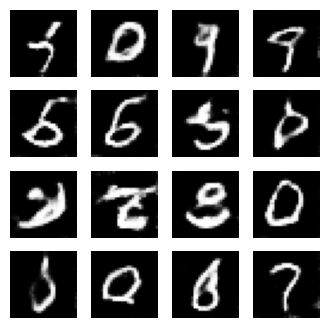

epoch: 13


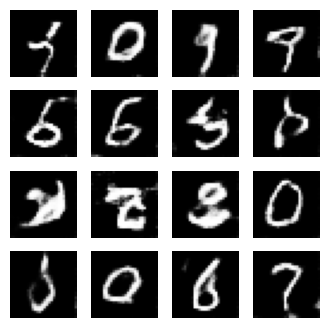

epoch: 14


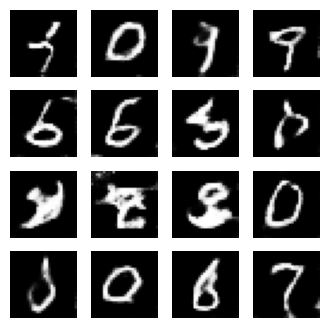

epoch: 15


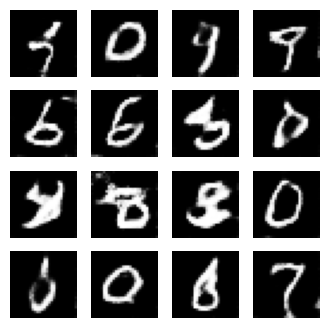

epoch: 16


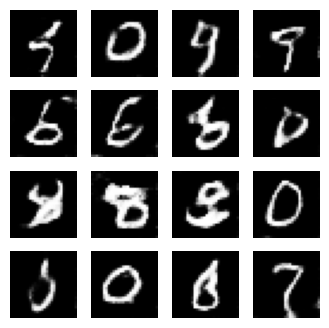

epoch: 17


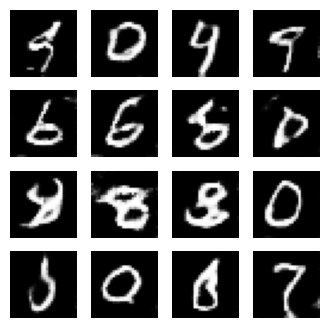

epoch: 18


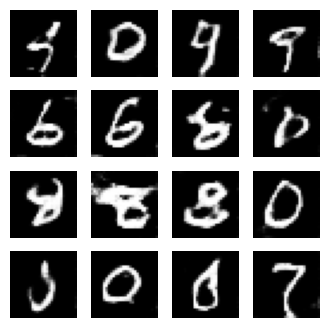

epoch: 19


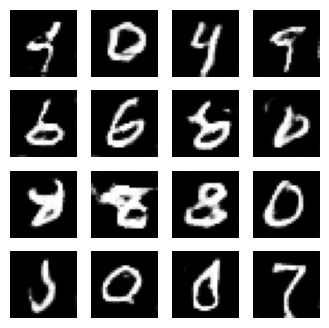

epoch: 20


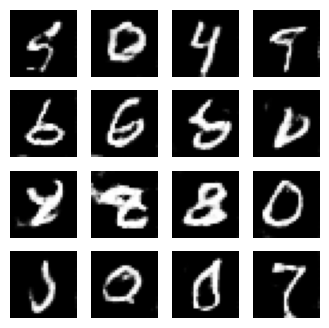

epoch: 21


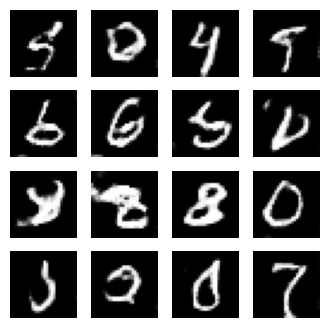

In [ ]:
#训练循环
for epoch in range(30):
    #初始化损失值
    D_epoch_loss = 0
    G_epoch_loss = 0
    count = len(train_dl)  #返回批次数
    #对数据集进行迭代
    for step, (img, _) in enumerate(train_dl):
        img = img.to(device)  #把数据放到设备上
        size = img.size(0)  #img的第一位是size,获取批次的大小
        random_seed = torch.randn(size, 100, device=device)

        #判别器训练(真实图片的损失和生成图片的损失),损失的构建和优化
        d_optimizer.zero_grad()  #梯度归零

        #判别器对于真实图片产生的损失
        real_output = dis(img)  #判别器输入真实的图片，real_output对真实图片的预测结果
        d_real_loss = loss_fn(real_output,
                              torch.ones_like(real_output)
                              )
        d_real_loss.backward()  #计算梯度

        #在生成器上去计算生成器的损失，优化目标是判别器上的参数
        generated_img = gen(random_seed)  #得到生成的图片
        #因为优化目标是判别器，所以对生成器上的优化目标进行截断
        fake_output = dis(generated_img.detach())  #判别器输入生成的图片，fake_output对生成图片的预测;detach会截断梯度，梯度就不会再传递到gen模型中了
        #判别器在生成图像上产生的损失
        d_fake_loss = loss_fn(fake_output,
                              torch.zeros_like(fake_output)
                              )
        d_fake_loss.backward()

        #判别器损失
        disc_loss = d_real_loss + d_fake_loss
        #判别器优化
        d_optimizer.step()

        #生成器上损失的构建和优化
        g_optimizer.zero_grad()  #先将生成器上的梯度置零
        fake_output = dis(generated_img)
        gen_loss = loss_fn(fake_output,
                           torch.ones_like(fake_output)
                           )  #生成器损失
        gen_loss.backward()
        g_optimizer.step()

        #累计每一个批次的loss
        with torch.no_grad():
            D_epoch_loss += disc_loss
            G_epoch_loss += gen_loss

    #求平均损失
    with torch.no_grad():
        D_epoch_loss /= count
        G_epoch_loss /= count
        D_loss.append(D_epoch_loss)
        G_loss.append(G_epoch_loss)
        print('epoch:', epoch)
        generate_and_save_images(gen, epoch, test_input)